In [ ]:
#TP final segunda entrega Deep Learning RED DENSA

In [ ]:
#importar librerias

import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.datasets import fetch_lfw_people

In [ ]:
#parametros de entrenamiento --> Explicar
# pocas épocas → underfitting
#demasiadas → overfitting

lr = 0.0001
epochs = 80 #antes era 50
batch_size = 100
np.random.seed(14)

In [ ]:
#Carga del dataset

#voy a ajust la definición de clases para garantizar el uso de los 7 personajes indicados en la consigna.”

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

# Utilizaremos solo imagenes de las 7 personas con mas de 70 imagenes disponibles. nota mia: cambie el resize para q sean imagenes mas chicas
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases   (y queda siendo el vector de etiquetas original del dataset)
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (125, 94)
n_samples: 1288
n_classes: 7


In [ ]:
# visualizacion del dataset
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

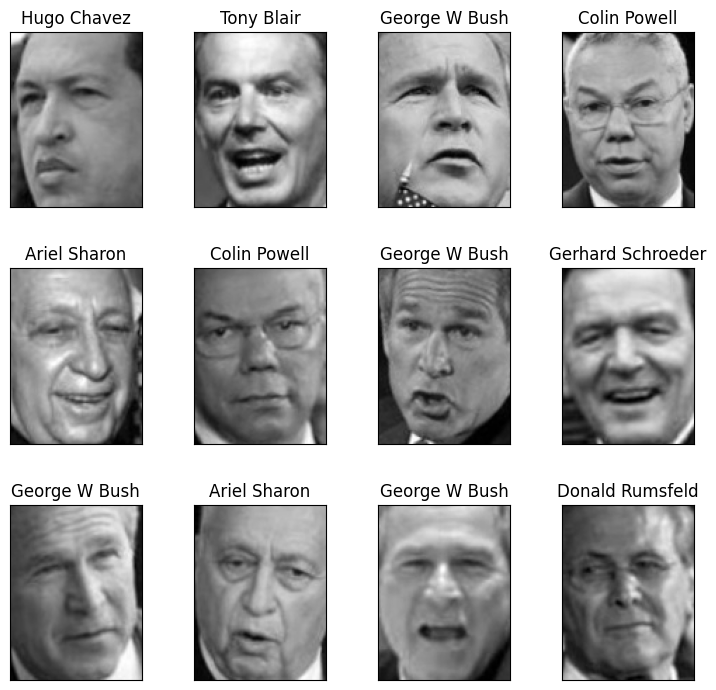

In [ ]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

In [ ]:
print(X[0])  # 0 es negro y 1 es blanco. este resultado es porque esta en escala de grises de la primera imagen:

[[0.99607843 0.99607843 0.9986928  ... 0.21699347 0.20261438 0.20653595]
 [0.99607843 0.9973857  0.99607843 ... 0.22222222 0.20261438 0.20653595]
 [0.9986928  0.9973857  0.99346405 ... 0.2248366  0.20522876 0.20522876]
 ...
 [0.3150327  0.29542485 0.2535948  ... 0.39346406 0.37908497 0.37124184]
 [0.29934642 0.2875817  0.2535948  ... 0.38562092 0.38300657 0.38300657]
 [0.27973858 0.27320263 0.25751635 ... 0.38431373 0.38039216 0.38039216]]


In [ ]:
#agrego esto para ver la primera persona a quien pertenece y es la 5
print(y[0])

5


In [ ]:
print(target_names[y[0]]) #me fijo quien detecta como la persona 5:


Hugo Chavez


In [ ]:
#uso de train_test_split como pide la consigna

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,      # entre 20% y 30%
    stratify=y,
    random_state=42
)

In [ ]:
#preparacion de los datos

X_train = X_train.astype('float32') #aca antes lo dividia por 255
X_test = X_test.astype('float32')

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

X_train.shape = (X_train.shape[0], np.prod(X_train.shape[1:]))
X_test.shape = (X_test.shape[0], np.prod(X_test.shape[1:]))


In [ ]:
#agrego esto porque esta desbalanceada la muestra osea capaz hay mas fotos de unos presidentes que otros
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(2.3793103448275863), 1: np.float64(0.7796610169491526), 2: np.float64(1.5164835164835164), 3: np.float64(0.34760705289672544), 4: np.float64(1.6829268292682926), 5: np.float64(2.6037735849056602), 6: np.float64(1.2777777777777777)}


In [ ]:
#crear + entrenar el modelo de red densa + evaluar el proceso de entrenamiento + testear

input_layer = Input(shape=X_train.shape[1:])

x = Flatten()(input_layer)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)



In [ ]:
early_stop = EarlyStopping(
    monitor="val_acc",
    mode="max",
    patience=8,                # cuántas épocas espera sin mejora
    restore_best_weights=True  # vuelve al mejor modelo
)

In [ ]:
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model.compile(
    #optimizer=Adadelta_optimizer,
    tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['acc', 'mse'])
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 11750)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 11750)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 512)            │     6,016,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,181,639 (23.58 MB)

 Trainable params: 6,181,639 (23.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# entrenar el modelo
start_time = time.time()
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    class_weight=class_weights,  #aca le agrego lo que puse arriba sobre la distribucion de las fotos
    shuffle=True,
    callbacks=[early_stop],
    verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - acc: 0.1266 - loss: 2.1253 - mse: 0.1322 - val_acc: 0.2236 - val_loss: 1.8883 - val_mse: 0.1204
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - acc: 0.1628 - loss: 2.0399 - mse: 0.1265 - val_acc: 0.1118 - val_loss: 1.9503 - val_mse: 0.1229
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - acc: 0.1413 - loss: 1.9990 - mse: 0.1277 - val_acc: 0.0870 - val_loss: 1.9375 - val_mse: 0.1225
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - acc: 0.1521 - loss: 1.9903 - mse: 0.1232 - val_acc: 0.2826 - val_loss: 1.8335 - val_mse: 0.1177
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - acc: 0.2050 - loss: 1.9800 - mse: 0.1212 - val_acc: 0.3168 - val_loss: 1.8683 - val_mse: 0.1193
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - acc: 0.1987 - loss: 1.9004 - mse: 0.1210 - val_acc: 0.3478 - val_loss: 1.8575 - val_mse: 0.1188
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - acc: 0.1902 - loss: 1.8529 - mse: 0.1210 - val

In [ ]:
#evaluar
history.history.keys()

dict_keys(['acc', 'loss', 'mse', 'val_acc', 'val_loss', 'val_mse'])

In [ ]:
pred = model.predict(X_test[:5]) #para ver como nos devuelve las probabilidades
print(pred.shape)
print(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
(5, 7)
[[0.46780536 0.38470483 0.03161698 0.09040271 0.00587313 0.00463634
  0.01496069]
 [0.24973954 0.4179488  0.02395384 0.05306391 0.0442992  0.07515218
  0.13584258]
 [0.00699585 0.03071738 0.00256702 0.80641425 0.03573044 0.04450059
  0.07307439]
 [0.00821745 0.01491807 0.01880092 0.7346835  0.10187569 0.0350006
  0.08650378]
 [0.09049611 0.5803854  0.13253602 0.08281147 0.01720349 0.00651208
  0.09005544]]


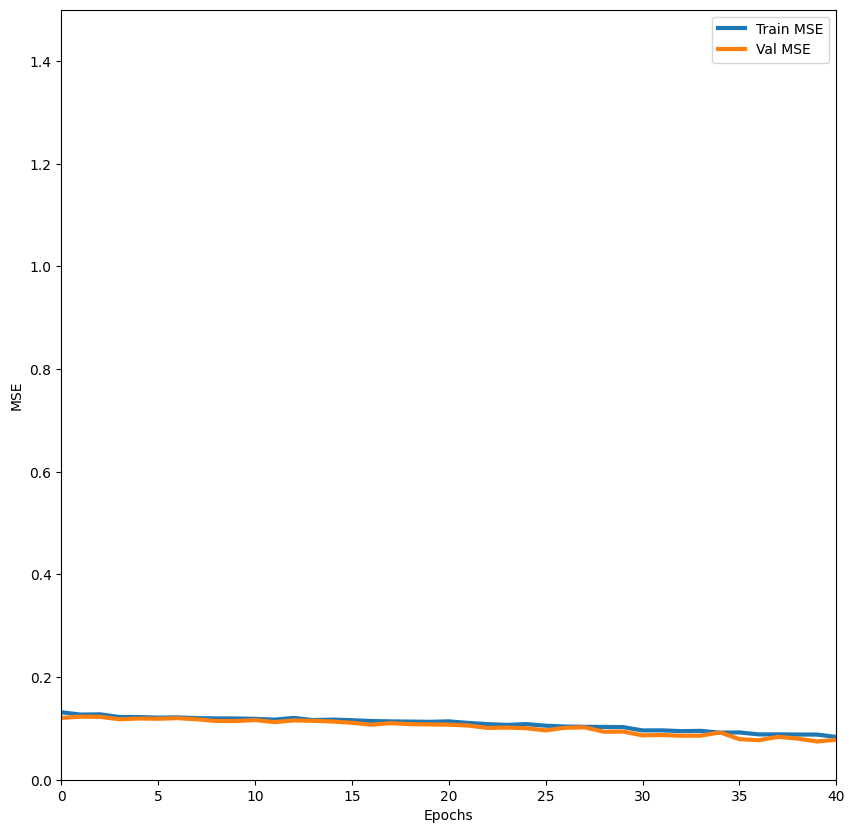

In [ ]:
# Juntas y subiendo - aprende y generaliza bien

# Train sube, Val se queda - aprende a memorizar, no a generalizar

# Train sube, Val baja - empieza a olvidar cómo generalizar

#Train MSE vs Val MSE - Cómo cambia el error promedio con las épocas

f = plt.figure(figsize=(10,10))
plt.plot(history.history['mse'], linewidth=3, label='Train MSE')
plt.plot(history.history['val_mse'], linewidth=3, label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.axis([0, 40, 0, 1.5])
plt.legend(loc='upper right')
plt.show()

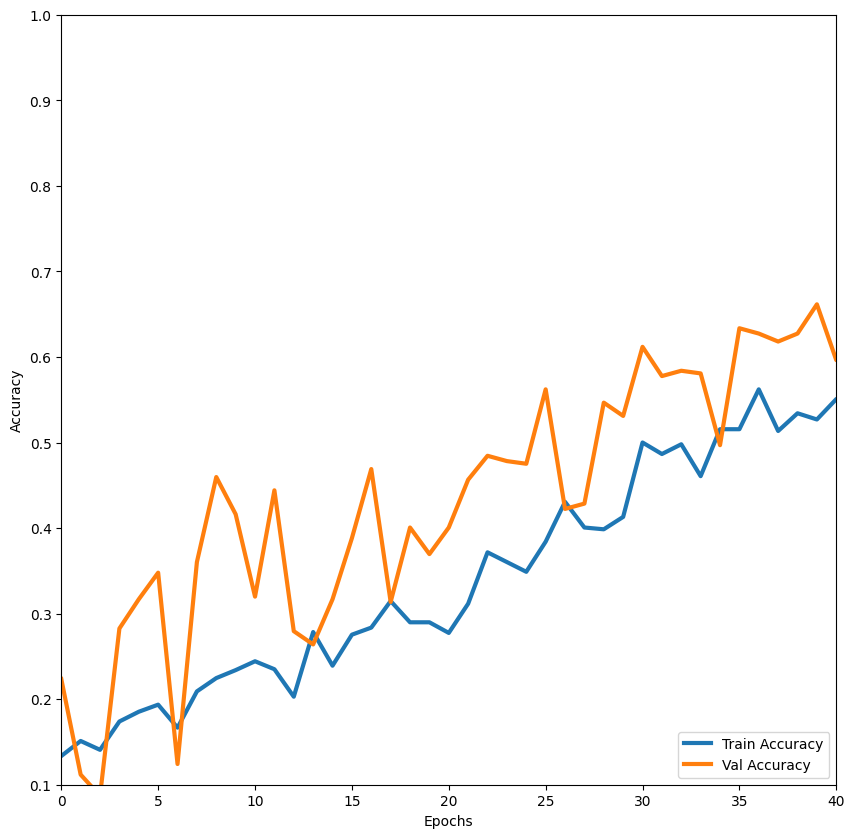

In [ ]:
#para ver como funciona el modelo (acc) con el tiempo
# entrenamiento vs validación
# ambas aumentan (cercanas) bien
# Si la accuracy aumenta pero la de validación se estanca o disminuye -> Overfit
# Si ambas accuracies son bajas -> underfitting (modelo con poca capacidad).
# Este análisis permite decidir si es necesario ajustar la arquitectura, regularización o épocas.

f = plt.figure(figsize=(10,10))
plt.plot(history.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0, 40, 0.1, 1])

plt.legend(loc='lower right')

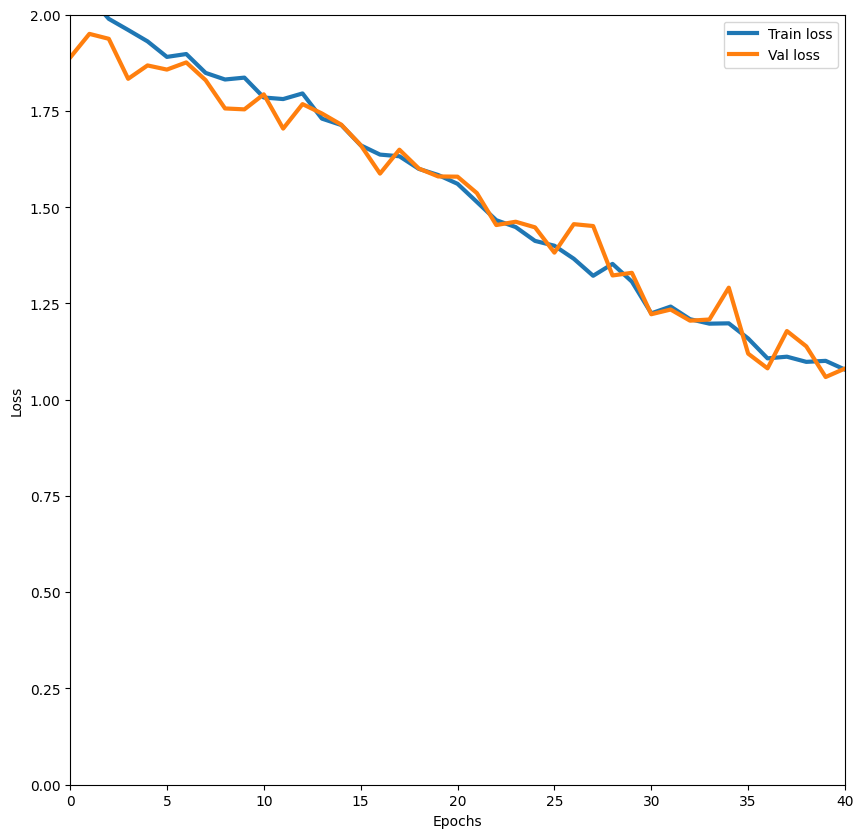

In [ ]:
# es el grafico para ver si el modelo esta aprendiendo de verdad, compara entrenamiento versus validacion. si bajan juntas esta bien
#Loss ↓ → el modelo mejora
#Loss ≈ plana → no aprende
#Loss ↑ → el entrenamiento se rompe
f = plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], linewidth=3, label='Train loss')
plt.plot(history.history['val_loss'], linewidth=3, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axis([0, 40, 0, 2])
plt.legend(loc='upper right')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# y_test está en one-hot → convertir a labels
y_test_labels = np.argmax(y_test, axis=1)

# predicciones del modelo
y_pred_proba = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# matriz de confusión
CM = confusion_matrix(y_test_labels, y_pred_labels)

print("CM shape:", CM.shape)

CM shape: (7, 7)


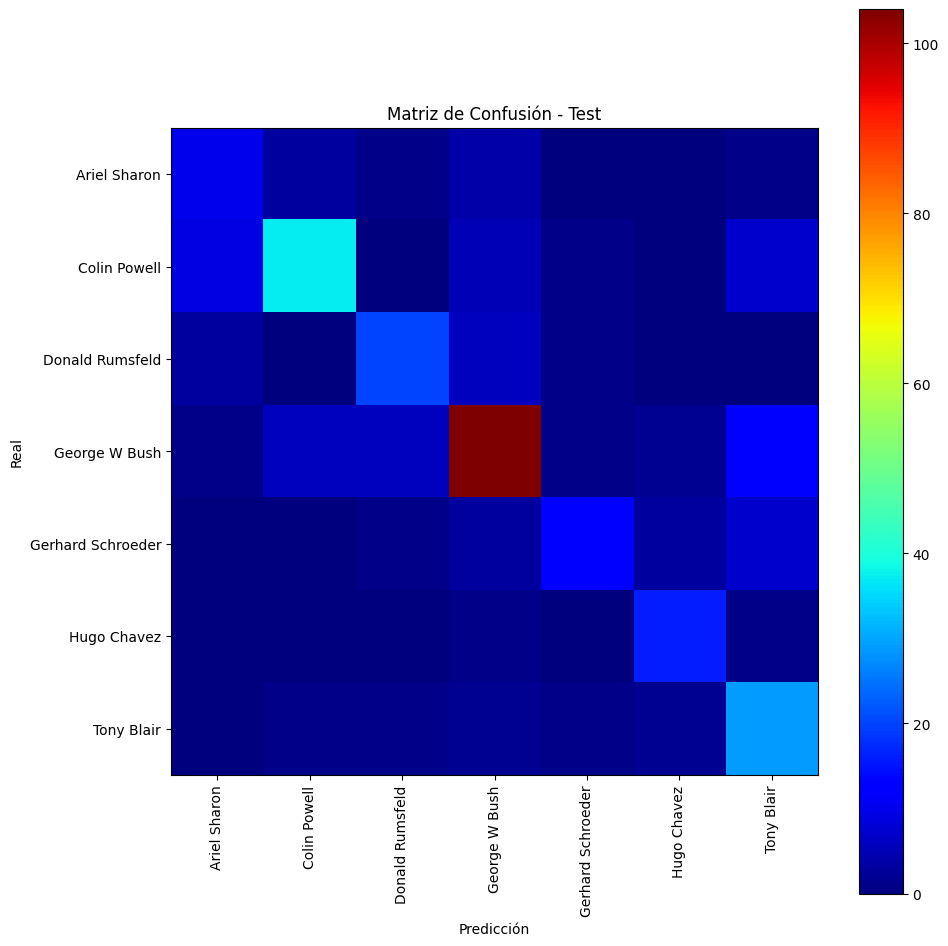

In [ ]:
str_labels = target_names   # nombres de personas
n = CM.shape[0]

plt.figure(figsize=(10,10))
plt.imshow(CM, cmap='jet')
plt.xticks(np.arange(n), str_labels, rotation=90)
plt.yticks(np.arange(n), str_labels)
plt.colorbar()
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()   #aca vemos que se dibuja la diagonal que vimos en clase, podria estar mejor si el acc diera mas alto, pero, en comparacion con la primera entrega, esta se ve mucho mejor


Conclusiones: Este modelo me quedó mejor que la primera entrega, con una mejor accuracy. Tanto la train y val accuracy crecen es decir el modelo aprende bien pero noto que tienen demasiado ruido. Tambien noto que train y val loss bajan juntas es decir, el modelo mejora conforme pasan las epocas. Despues por ultimo, el grafico de la Matriz de confusion, a diferencia de la primera entrega en este si podemos ver la diagonal marcada, aunque si bien la accuracy no dio tan alta, si visualmente podemos ver que el modelo no esta tan errado.